<a href="https://colab.research.google.com/github/dailyLi/fake_news_NLP/blob/main/Fake_news_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction

Given a sample of fake news and true news, i.e. paragraphs of text and the label associated with them, can we learn to predict or judge whether a piece of news is fake or true?

This project aims at building NLP classification model using Recurrent Neural Networks (RNN) with Keras for identifying fake news and true/real news. The data sets are obtained from Kaggle: https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset 

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
import tensorflow as tf 
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.model_selection import train_test_split
import seaborn as sns

## Data Preparation

Import csv files to Colab.

In [2]:
from google.colab import files
uploaded = files.upload()

Saving Fake.csv to Fake.csv


In [3]:
import io
df_fake = pd.read_csv(io.BytesIO(uploaded["Fake.csv"]))

In [4]:
from google.colab import files
uploaded = files.upload()

Saving True.csv to True.csv


In [5]:
df_true = pd.read_csv(io.BytesIO(uploaded["True.csv"]))

In [6]:
df_fake.describe()

,title,text,subject,date
count,23481,23481,23481,23481
unique,17903,17455,6,1681
top,MEDIA IGNORES Time That Bill Clinton FIRED His...,,News,"May 10, 2017"
freq,6,626,9050,46


In [7]:
df_true.describe()

,title,text,subject,date
count,21417,21417,21417,21417
unique,20826,21192,2,716
top,Factbox: Trump fills top jobs for his administ...,(Reuters) - Highlights for U.S. President Dona...,politicsNews,"December 20, 2017"
freq,14,8,11272,182


Encode the original data with 0 for fake news and 1 for true news, then combine the two data sets into one.

In [8]:
df_fake['class'] = 0 
df_true['class'] = 1
df_all = pd.concat([df_fake, df_true], ignore_index=True, sort=False)
df_all

,title,text,subject,date,class
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0
...,...,...,...,...,...
44893,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017",1
44894,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017",1
44895,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017",1
44896,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017",1


Split the data set into training and testing subsets, with 80% for training and 20% for testing.

In [9]:
features = df_all['text']
targets = df_all['class']

X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.20, random_state=18)

Tokenize the text for NLP.

In [10]:
max_vocab = 10000
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(X_train)

In [11]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [12]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, padding='post', maxlen=256)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, padding='post', maxlen=256)

## Modeling

Building RNN
- Embedding layer: represent words by dense vectors where a vector represents the projection of the word into a continuous vector space.
- Bidirectional layers: enable straight (past) and reverse (future) traversal of input words so that LSTM can use context when predicting the next sample.
- Dense: change the dimension of the preceding bidirectional layer so that the model can define the relationship between the values of the data.
- Dropout: regularize the model by probabilistically excluding neurons from activation and weight updates while training a network. The purpose is to reduce overfitting and improve model performance.
- Dense: again change the dimension and generate final result.

In [13]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_vocab, 32),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          320000    
                                                                 
 bidirectional (Bidirectiona  (None, None, 128)        49664     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 32)               18560     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 6

In the training session, we use early stop that automatically stops training when a monitored metric has stopped improving. Here we use "accuracy" as the metric.

In [14]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10,validation_split=0.1, batch_size=30, shuffle=True, callbacks=[early_stop])

Epoch 1/10
1078/1078 [==============================] - 416s 379ms/step - loss: 0.3140 - accuracy: 0.8357 - val_loss: 0.2318 - val_accuracy: 0.8953
Epoch 2/10
1078/1078 [==============================] - 406s 377ms/step - loss: 0.1184 - accuracy: 0.9587 - val_loss: 0.0738 - val_accuracy: 0.9766
Epoch 3/10
1078/1078 [==============================] - 405s 376ms/step - loss: 0.0633 - accuracy: 0.9854 - val_loss: 0.0799 - val_accuracy: 0.9811
Epoch 4/10
1078/1078 [==============================] - 404s 374ms/step - loss: 0.0446 - accuracy: 0.9905 - val_loss: 0.0427 - val_accuracy: 0.9894
Epoch 5/10
1078/1078 [==============================] - 406s 377ms/step - loss: 0.0446 - accuracy: 0.9885 - val_loss: 0.0309 - val_accuracy: 0.9891
Epoch 6/10
1078/1078 [==============================] - 407s 377ms/step - loss: 0.0223 - accuracy: 0.9945 - val_loss: 0.0266 - val_accuracy: 0.9944
Epoch 7/10
1078/1078 [==============================] - 407s 377ms/step - loss: 0.0370 - accuracy: 0.9899 - val_

Plot the training vs. validation loss and accurary of the 8 epoches.

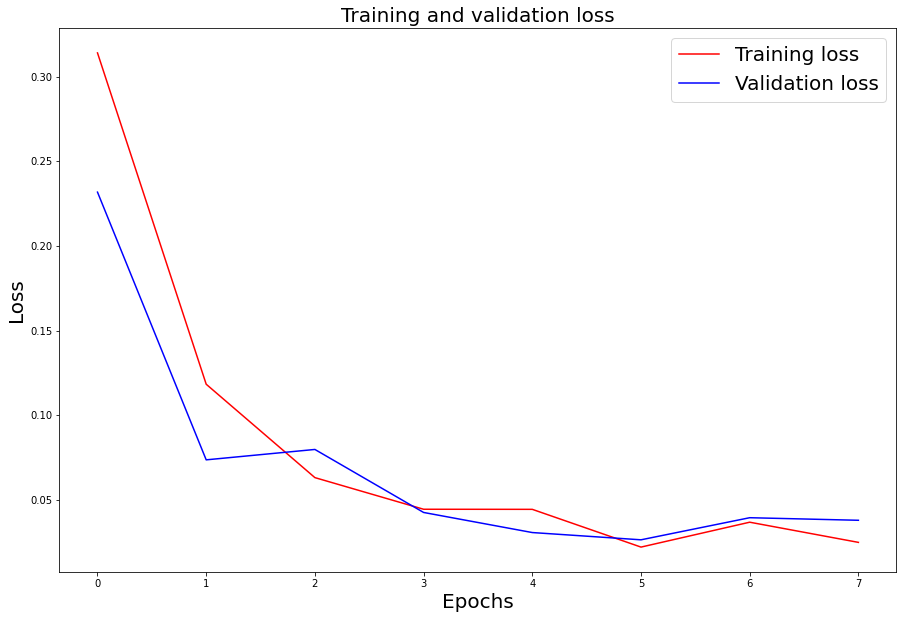

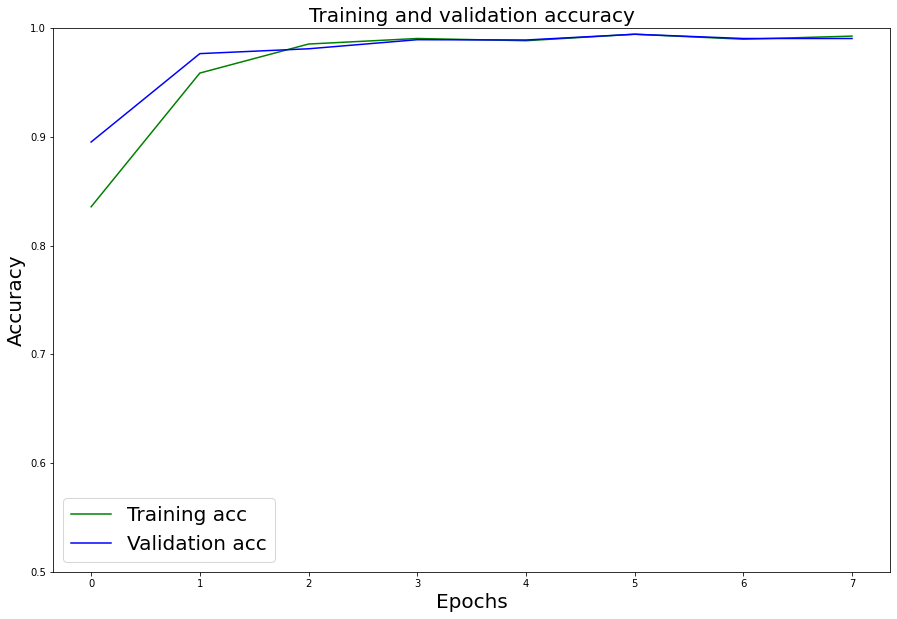

In [19]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = history.epoch

plt.figure(figsize=(15,10))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Loss', size=20)
plt.legend(prop={'size': 20})
plt.show()

plt.figure(figsize=(15,10))
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Accuracy', size=20)
plt.legend(prop={'size': 20})
plt.ylim((0.5,1))
plt.show()

## Evaluation

In [16]:
model.evaluate(X_test, y_test)

281/281 [==============================] - 22s 79ms/step - loss: 0.0308 - accuracy: 0.9938


[0.030756091699004173, 0.9937639236450195]

In [17]:
pred = model.predict(X_test)

binary_predictions = []

for i in pred:
    if i >= 0.5:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0)

print('Accuracy on testing set:', accuracy_score(binary_predictions, y_test))
print('Precision on testing set:', precision_score(binary_predictions, y_test))
print('Recall on testing set:', recall_score(binary_predictions, y_test))

Accuracy on testing set: 0.9937639198218263
Precision on testing set: 0.9962945808244558
Recall on testing set: 0.9907876554583142


[Text(0, 0.5, 'no'), Text(0, 1.5, 'yes')]

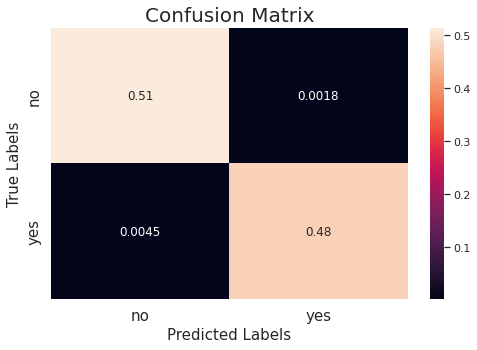

In [31]:
matrix = confusion_matrix(binary_predictions, y_test, normalize='all')
plt.figure(figsize=(8, 5))
ax= plt.subplot()
sns.set(font_scale=1)
sns.heatmap(matrix, annot=True, ax = ax)

ax.set_xlabel('Predicted Labels', size=15)
ax.set_ylabel('True Labels', size=15)
ax.set_title('Confusion Matrix', size=20) 
ax.xaxis.set_ticklabels(["no","yes"], size=15)
ax.yaxis.set_ticklabels(["no","yes"], size=15)